#### Friday, February 23, 2024

https://milvus.io/docs/image_similarity_search.md

https://github.com/towhee-io/examples/blob/main/image/reverse_image_search/1_build_image_search_engine.ipynb

mamba activate milvus

Nice! I got all of this to run!

## Index

* [Introduction](#intro)
* [Preparation](#preparation)
* [Reverse Image Search](#reverse-image-search)
    * [Configuration](#configuration)
    * [Embedding pipeline](#embedding-pipeline)
    * [Steps](#steps)
        * [1. Create Milvus collection](#step1)
        * [2. Insert data](#step2)
        * [3. Search](#step3)
* [Benchmark](#benchmark)


# Reverse Image Search powered by Towhee & Milvus <a class="anchor" id="intro"></a>

Reverse image search takes an image as input and retrieves most similar images based on its content. The basic idea behind semantic image search is to represent each image as an embedding of features extracted by a pretrained deep learning model. Then image retrieval can be performed by storing & comparing image embeddings.

This notebook illustrates how to build an reverse image search engine from scratch using [Towhee](https://towhee.io/) and [Milvus](https://milvus.io/). We will go through procedures with example data. With this tutorial, you will learn how to build and evaluate a reverse image search system.

<img src="https://github.com/towhee-io/examples/raw/main/image/reverse_image_search/workflow.png" width = "60%" height = "60%" align=center />

## Preparation <a class="anchor" id="preparation"></a>

To get ready for building the image search engine, we need to install some python packages, download example data, and start Milvus service in advance.

**Install dependencies**

First we need to install dependencies such as towhee, opencv-python and pillow. Please note you should install proper versions based on your environment.

| package | version |
| -- | -- |
| towhee | 1.1.0 |
| opencv-python | |
| pillow | |

In [1]:
# ! python -m pip install -q towhee opencv-python pillow

**Prepare data**

Here we use a subset of the [ImageNet](https://www.image-net.org/) dataset (100 classes). The example data is available on [Github](https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip). You can follow command below to download it. The example data is organized as follows:

- train: directory of candidate images, 10 images per class from ImageNet train data
- test: directory of query images, 1 image per class from ImageNet test data
- reverse_image_search.csv: a csv file containing *id, path, and label* for each candidate image

In [2]:
# ! curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip -O
# ! unzip -q -o reverse_image_search.zip

**Start Milvus**

Milvus is the most advanced open-source vector database built for AI applications and supports nearest neighbor embedding search across tens of millions of entries. You can refer to [Milvus Guide](https://milvus.io/docs/v2.1.x/install_standalone-docker.md) for more details and options of Milvus installation. 

This notebook uses [milvus 2.2.10](https://milvus.io/docs/v2.2.x/install_standalone-docker.md) and [pymilvus 2.2.11](https://milvus.io/docs/release_notes.md#2210).

In [3]:
# ! wget https://github.com/milvus-io/milvus/releases/download/v2.2.10/milvus-standalone-docker-compose.yml -O docker-compose.yml
# ! docker-compose up -d
# ! python -m pip install -q pymilvus==2.2.11

## Reverse Image Search <a class="anchor" id="reverse-image-search"></a>

In this section, we will learn how to build the image search engine using Towhee. Towhee is a framework that provides ETL for unstructured data using SoTA machine learning models. It allows to create data processing pipelines. It also has built-in operators for different purposes, such as generating image embeddings, inserting data into Milvus collection, and querying across Milvus collection.


### Configuration <a class="anchor" id="configuration"></a>

For later use, we import packages & set parameters at the beginning. You are able to change parameters according to your needs and environment. Please note that the embedding dimension `DIM` should match the selected model name `MODEL`.

By default, this tutorial selects a pretrained model 'resnet50' to extract image embeddings. It sets ['IVF_FLAT'](https://milvus.io/docs/v2.0.x/index.md#IVF_FLAT) as index and ['L2'](https://milvus.io/docs/v2.0.x/metric.md#Euclidean-distance-L2) as distance metric for Milvus configuration. `TOPK` determines how many search results returned, which defaults to 10.

In [1]:
import csv
from glob import glob
from pathlib import Path
from statistics import mean

from towhee import pipe, ops, DataCollection
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

/home/rob/miniforge3/envs/milvus/lib/python3.11/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
# Towhee parameters
MODEL = 'resnet50'
DEVICE = None # if None, use default device (cuda is enabled if available)

# Milvus parameters
HOST = '127.0.0.1'
PORT = '19530'
TOPK = 10
DIM = 2048 # dimension of embedding extracted by MODEL
COLLECTION_NAME = 'reverse_image_search'
INDEX_TYPE = 'IVF_FLAT'
METRIC_TYPE = 'L2'

# path to csv (column_1 indicates image path) OR a pattern of image paths
INSERT_SRC = 'reverse_image_search.csv'
QUERY_SRC = './test/*/*.JPEG'

### Embedding pipeline <a class="anchor" id="embedding-pipeline"></a>

As mentioned above, the similarity search actually happens to vectors. So we need to convert each image into an embedding. To pass image path into the image embedding operator, we use a function streamly reads image path given a pattern or a csv. Thus the embedding pipeline generates image embeddings given a pattern or csv of image path(s).

In [3]:
# Load image path
def load_image(x):
    if x.endswith('csv'):
        with open(x) as f:
            reader = csv.reader(f)
            next(reader)
            for item in reader:
                yield item[1]
    else:
        for item in glob(x):
            yield item
            
# Embedding pipeline
p_embed = (
    pipe.input('src')
        .flat_map('src', 'img_path', load_image)
        .map('img_path', 'img', ops.image_decode())
        .map('img', 'vec', ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
)

img_path,img,vec
./test/goldfish/n01443537_3883.JPEG,,"[0.0, 0.0, 0.0, ...] shape=(2048,)"

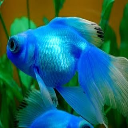

<Figure size 128x128 with 0 Axes>

In [4]:
# Display embedding result, no need for implementation
p_display = p_embed.output('img_path', 'img', 'vec')
DataCollection(p_display('./test/goldfish/*.JPEG')).show()

# 3m 49.0s

### Steps <a class="anchor" id="steps"></a>

With work above done, we are ready to build and try the image search engine. The core procedure includes 3 steps:

1. create a Milvus collection
2. insert data into collection
3. query image across database

#### 1. Create Milvus collection <a class="anchor" id="step1"></a>

Before insert or search data, we need to have a collection. This step creates a new collection using configurations above. Please note that it will delete the collection first if it already exists.

In [5]:
# Create milvus collection (delete first if exists)
def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
        FieldSchema(name='path', dtype=DataType.VARCHAR, description='path to image', max_length=500, 
                    is_primary=True, auto_id=False),
        FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, description='image embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    index_params = {
        'metric_type': METRIC_TYPE,
        'index_type': INDEX_TYPE,
        'params': {"nlist": 2048}
    }
    collection.create_index(field_name='embedding', index_params=index_params)
    return collection

Connect to Milvus with `HOST` & `PORT` and create collection with `COLLECTION_NAME` & `DIM`:

In [6]:
# Connect to Milvus service
connections.connect(host=HOST, port=PORT)

# Create collection
collection = create_milvus_collection(COLLECTION_NAME, DIM)
print(f'A new collection created: {COLLECTION_NAME}')

A new collection created: reverse_image_search


In [7]:
# I had to add this line myself ... 
collection.load()

#### 2. Insert data <a class="anchor" id="step2"></a>

This step uses an **insert pipeline** to insert image embeddings into Milvus collection. The insert pipeline consists of the embedding pipeline and the Milvus insert operator.

In [8]:
# Insert pipeline
p_insert = (
        p_embed.map(('img_path', 'vec'), 'mr', ops.ann_insert.milvus_client(
                    host=HOST,
                    port=PORT,
                    collection_name=COLLECTION_NAME
                    ))
          .output('mr')
)

Insert all candidate images for  `INSERT_SRC`:

In [9]:
# Insert data
p_insert(INSERT_SRC)

# Check collection
# print('Number of data inserted:', collection.num_entities)

# 12.2s

In [10]:
# Wow ... I also had to add this here to make it work ... 
collection.flush()

In [11]:
# Check collection
print('Number of data inserted:', collection.num_entities)

Number of data inserted: 1000


#### 3. Search <a class="anchor" id="step3"></a>

An search pipeline queries image embeddings across Milvus collection given a pattern or csv of image path(s). It attaches a Milvus search operator to the embedding pipeline. The script below returns paths of query image and search results. You can modify `output()` to return values of different items. 

In [12]:
# Search pipeline
p_search_pre = (
        p_embed.map('vec', ('search_res'), ops.ann_search.milvus_client(
                    host=HOST, port=PORT, limit=TOPK,
                    collection_name=COLLECTION_NAME))
               .map('search_res', 'pred', lambda x: [str(Path(y[0]).resolve()) for y in x])
#                .output('img_path', 'pred')
)
p_search = p_search_pre.output('img_path', 'pred')

Query an example image 'test/goldfish/*.JPEG':

In [13]:
# Search for example query image(s)
collection.load()
dc = p_search('test/goldfish/*.JPEG')

# Display search results with image paths
DataCollection(dc).show()

img_path,pred
test/goldfish/n01443537_3883.JPEG,/home/rob/Data/Documents/Github/rkaunismaa/LLaMa2_PlayGround/LangChain/milvus/train/goldfish/n01443537_1903.JPEG /home/rob/Data/Documents/Github/rkaunismaa/LLaMa2_PlayGround/LangChain/milvus/train/goldfish/n01443537_2819.JPEG /home/rob/Data/Documents/Github/rkaunismaa/LLaMa2_PlayGround/LangChain/milvus/train/goldfish/n01443537_1415.JPEG /home/rob/Data/Documents/Github/rkaunismaa/LLaMa2_PlayGround/LangChain/milvus/train/goldfish/n01443537_7751.JPEG /home/rob/Data/Documents/Github/rkaunismaa/LLaMa2_PlayGround/LangChain/milvus/train/goldfish/n01443537_2637.JPEG /home/rob/Data/Documents/Github/rkaunismaa/LLaMa2_PlayGround/LangChain/milvus/train/goldfish/n01443537_7376.JPEG /home/rob/Data/Documents/Github/rkaunismaa/LLaMa2_PlayGround/LangChain/milvus/train/goldfish/n01443537_19638.JPEG /home/rob/Data/Documents/Github/rkaunismaa/LLaMa2_PlayGround/LangChain/milvus/train/goldfish/n01443537_9816.JPEG /home/rob/Data/Documents/Github/rkaunismaa/LLaMa2_PlayGround/LangChain/milvus/train/goldfish/n01443537_6743.JPEG /home/rob/Data/Documents/Github/rkaunismaa/LLaMa2_PlayGround/LangChain/milvus/train/black_widow/n01774384_6247.JPEG


img,pred_images
,

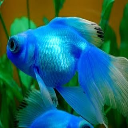
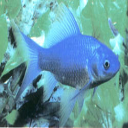
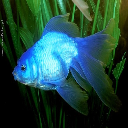
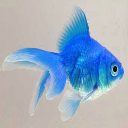
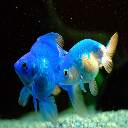
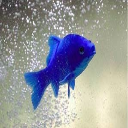
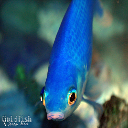
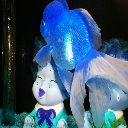
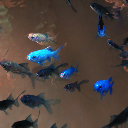
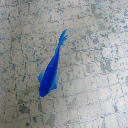
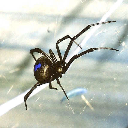

In [14]:
# Display search results with images, no need for implementation

import cv2
from towhee.types.image import Image

def read_images(img_paths):
    imgs = []
    for p in img_paths:
        imgs.append(Image(cv2.imread(p), 'BGR'))
    return imgs

p_search_img = (
    p_search_pre.map('pred', 'pred_images', read_images)
                .output('img', 'pred_images')
)
DataCollection(p_search_img('test/goldfish/*.JPEG')).show()

## Benchmark <a class="anchor" id="benchmark"></a>

We have successfully built a image search engine, which allows to insert and query image. However, we don't know its performance. To evaluate the system against ground truth, we consider images in the same class as relevant items. You can follow steps below or design a benchmark by your own to compare search results with all relevant items in dataset. This benchmark measures the system with the metric of [mAP](https://www.educative.io/answers/what-is-the-mean-average-precision-in-information-retrieval), which is mean average precision over all queries.


### Helpful functions

For each query image, we expect to get images of the same class from the database. So we define a function which returns a list of image paths from candidates as the ground truth given a query image path. The ground truth should share the same class or category as the query image.

In addition, we manually define a function to calculate average precision given predictions and expected results.

In [15]:
# Get ground truth by path of query image
def ground_truth(path):
    train_path = str(Path(path).parent).replace('test', 'train')
    return [str(Path(x).resolve()) for x in glob(train_path + '/*.JPEG')]

# Calculate Average Precision by a list of predictions and a list of ground truths
def get_ap(pred: list, gt: list):
    ct = 0
    score = 0.
    for i, n in enumerate(pred):
        if n in gt:
            ct += 1
            score += (ct / (i + 1))
    if ct == 0:
        ap = 0
    else:
        ap = score / ct
    return ap

### Evaluation pipeline

With helpful functions defined above, we are able to build a evaluateion pipeline based on the search pipeline. It searches for each query image and compares search results with ground truth. Then the pipeline outputs the Average Precision (AP) for each query.

In [16]:
# Evaluation pipeline returns AP
p_eval = (
    p_search_pre.map('img_path', 'gt', ground_truth)
                .map(('pred', 'gt'), 'ap', get_ap)
                .output('ap')
)

### Performance

Now we are able to run the evaluation pipeline over all test data. Then we calculate the mean value of AP of all queries to get the final performance in mAP.

At the end, a table records performance and qps of some popular models tested in our environment. You can try different models and configurations by your own. Please note that mAP and qps will be affected by versions of denpendencies and device. You are encouraged to explore more based on this tutorial.

In [17]:
import time

# Run evaluation pipeline over all test data
start = time.time()
bm = p_eval('test/*/*.JPEG')
end = time.time()

# Group AP in a list
res = DataCollection(bm).to_list()

# Calculate mAP
mAP = mean([x.ap for x in res])

print(f'mAP@{TOPK}: {mAP}')
print(f'qps: {len(res) / (end - start)}')

mAP@10: 0.8868301760519023
qps: 76.76778695463177


#### Model performance:

| model | dim | mAP@10 | qps |
| -- | -- | -- | -- |
| resnet50 | 2048 | 0.886 | 35 |
| vgg16 | 512 | 0.658 | 53 |
| vit_base_patch16_224 | 768 | 0.962 | 40 |
| tf_efficientnet_b7 | 2560 | 0.983 | 16 |